In [5]:
%pylab inline
import theano as theano
import theano.tensor as T
import operator
import os, csv

Populating the interactive namespace from numpy and matplotlib


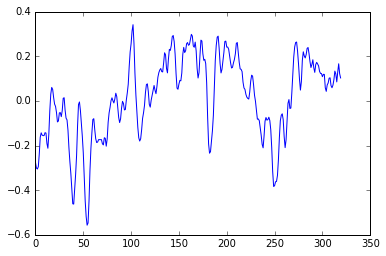

In [6]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [10]:
class RNNTheano:
    
    def __init__(self, word_dim=1, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        V = np.random.normal(0,0.1, (word_dim, hidden_dim))
        W = np.random.normal(0,0.1, (hidden_dim, hidden_dim))
        b1 = np.random.normal(0,0.1, (hidden_dim))
        # Theano: Created shared variables
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))      
        self.b1 = theano.shared(name='b1', value=b1.astype(theano.config.floatX))      
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        V, W, b1 = self.V, self.W, self.b1
        x = T.ivector('x')
        def forward_prop_step(x_t, s_t_prev, V, W, b1):
            s_t = T.tanh(W.dot(s_t_prev)+b1)
            o_t = V.dot(s_t)
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            outputs_info=[None, dict(initial=T.zeros(self.hidden_dim))],
            non_sequences=[V, W, b1],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = o
        o_error = T.mean((o - x) ** 2)
        
        # Gradients
        dV, dW, db1 = T.grad(o_error, [V, W, b1])

        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x], o_error)
        self.bptt = theano.function([x], [dV, dW, db1])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        self.sgd_step = theano.function([x,learning_rate], 
                      updates=[(self.V, self.V - learning_rate * dV),
                              (self.W, self.W - learning_rate * dW),
                              (self.b1, self.b1 - learning_rate * db1)])
    
    def calculate_loss(self, x):
        return self.ce_error(x)

In [11]:
def train_with_sgd(model, x, learning_rate=0.0003, nepoch=100):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        loss = model.calculate_loss(x)
        losses.append(loss)
        # One SGD step
        model.sgd_step(x, learning_rate)
    return losses


In [12]:
model = RNNTheano()

/usr/lib/python3.5/site-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x7f011768c6d8>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x7f011768c6d8>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/usr/lib/python3.5/site-packages/theano/gof/opt.py", line 196, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/usr/lib/python3.5/site-packages/theano/gof/opt.py", line 82, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/usr/lib/python3.5/site-packages/theano/tensor/opt.py", line 5499, in apply
    new_outputs = self.optimizer(node)
  File "/usr/lib/python3.5/site-packages/theano/tensor/opt.py", line 54

In [37]:
X_train = data[4][:,0]
model.sgd_step(X_train, 0.0003)

TypeError: ('Bad input argument to theano function with name "<ipython-input-34-b99ea8b14a65>:50"  at index 0(0-based)', 'TensorType(int32, vector) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function".', array([  2.35350000e-01,   1.30760000e-01,   3.25700000e-02,
        -6.73300000e-02,  -1.33060000e-01,  -1.06620000e-01,
        -4.19400000e-02,   4.85700000e-02,   1.49830000e-01,
         1.87030000e-01,   2.14650000e-01,   2.60230000e-01,
         2.40090000e-01,   1.23610000e-01,  -6.83500000e-02,
        -1.90790000e-01,  -1.23400000e-01,  -3.09000000e-03,
        -6.83000000e-03,  -1.37810000e-01,  -1.94750000e-01,
        -7.16300000e-02,  -2.04200000e-02,  -1.20310000e-01,
        -1.44130000e-01,  -1.46670000e-01,  -3.06970000e-01,
        -5.23700000e-01,  -6.37590000e-01,  -6.15220000e-01,
        -4.68160000e-01,  -2.59980000e-01,  -1.02760000e-01,
        -4.25600000e-02,  -5.68800000e-02,  -6.69400000e-02,
        -4.71000000e-03,  -4.31000000e-03,  -1.38150000e-01,
        -2.07040000e-01,  -1.59180000e-01,  -1.17540000e-01,
        -1.36890000e-01,  -2.40880000e-01,  -3.00170000e-01,
        -1.89930000e-01,  -8.00900000e-02,  -9.00600000e-02,
        -1.07230000e-01,  -1.22820000e-01,  -2.16570000e-01,
        -2.88740000e-01,  -2.56850000e-01,  -2.89970000e-01,
        -4.67460000e-01,  -5.94270000e-01,  -5.69900000e-01,
        -5.32720000e-01,  -5.35670000e-01,  -4.32460000e-01,
        -2.75190000e-01,  -2.92550000e-01,  -3.92140000e-01,
        -3.99160000e-01,  -3.65560000e-01,  -2.80060000e-01,
        -1.60630000e-01,  -1.65830000e-01,  -3.02220000e-01,
        -4.28740000e-01,  -4.39710000e-01,  -3.44950000e-01,
        -2.42340000e-01,  -1.93610000e-01,  -1.79560000e-01,
        -1.42020000e-01,  -1.09950000e-01,  -1.57970000e-01,
        -2.35380000e-01,  -2.80380000e-01,  -2.67660000e-01,
        -2.01000000e-01,  -2.14880000e-01,  -3.14600000e-01,
        -3.20090000e-01,  -2.37920000e-01,  -1.55740000e-01,
        -2.94700000e-02,   9.27200000e-02,   6.59400000e-02,
        -8.48400000e-02,  -2.71600000e-01,  -5.03310000e-01,
        -6.76470000e-01,  -6.58540000e-01,  -5.33100000e-01,
        -3.68180000e-01,  -1.62500000e-01,  -2.49100000e-02,
        -1.81500000e-02,  -9.41300000e-02,  -2.14570000e-01,
        -3.36740000e-01,  -4.06230000e-01,  -4.29070000e-01,
        -4.61590000e-01,  -4.99180000e-01,  -5.10380000e-01,
        -4.88390000e-01,  -3.97050000e-01,  -2.86820000e-01,
        -2.33000000e-01,  -1.60260000e-01,  -6.37000000e-02,
        -2.11900000e-02,   3.19500000e-02,   1.44550000e-01,
         2.28120000e-01,   2.17690000e-01,   1.50170000e-01,
         8.09700000e-02,   5.33300000e-02,   1.04690000e-01,
         1.61650000e-01,   1.44020000e-01,   1.02410000e-01,
         6.18200000e-02,   5.42800000e-02,   1.01250000e-01,
         6.70700000e-02,  -7.97300000e-02,  -2.22740000e-01,
        -2.98350000e-01,  -2.39860000e-01,  -9.49400000e-02,
         3.73000000e-03,   6.10700000e-02,   5.93500000e-02,
        -1.82900000e-02,  -5.36900000e-02,  -4.00500000e-02,
        -5.01000000e-02,  -4.74600000e-02,  -3.15300000e-02,
        -2.91000000e-02,  -3.17800000e-02,  -8.96400000e-02,
        -1.59600000e-01,  -1.30550000e-01,  -5.17900000e-02,
         5.98700000e-02,   1.87300000e-01,   1.87570000e-01,
         1.64900000e-01,   2.28460000e-01,   1.66100000e-01,
         8.15000000e-03,  -1.11300000e-02,   6.82200000e-02,
         1.21980000e-01,   1.07920000e-01,   6.26500000e-02,
         3.12300000e-02,  -9.40000000e-04,   5.20500000e-02,
         1.72520000e-01,   1.69890000e-01,   9.19400000e-02,
         2.68000000e-02,  -7.62800000e-02,  -1.02180000e-01,
         1.72200000e-02,   1.42380000e-01,   1.92690000e-01,
         1.42880000e-01,   4.22500000e-02,   1.30100000e-02,
         1.94500000e-02,   3.36500000e-02,   1.41050000e-01,
         2.14720000e-01,   1.48560000e-01,   1.21320000e-01,
         1.31020000e-01,   4.74600000e-02,   5.13000000e-03,
         6.89100000e-02,   1.01950000e-01,   7.62600000e-02,
         3.44300000e-02,  -4.69000000e-03,  -5.09000000e-03,
         2.92100000e-02,   2.84400000e-02,  -1.01900000e-02,
         1.02300000e-02,   6.87100000e-02,   6.98000000e-02,
         5.43600000e-02,   6.64100000e-02,   1.13800000e-01,
         1.89760000e-01,   1.66710000e-01,   3.73100000e-02,
        -2.10300000e-02,   1.50400000e-02,   4.36200000e-02,
         2.50500000e-02,   3.44000000e-03,   6.52300000e-02,
         1.53300000e-01,   1.13750000e-01,  -1.61100000e-02,
        -1.12110000e-01,  -1.71730000e-01,  -1.75520000e-01,
        -1.07140000e-01,  -8.29700000e-02,  -1.20430000e-01,
        -1.30630000e-01,  -1.54900000e-01,  -1.91300000e-01,
        -1.76090000e-01,  -1.82610000e-01,  -2.34000000e-01,
        -2.70040000e-01,  -3.04090000e-01,  -3.27760000e-01,
        -3.15520000e-01,  -2.44860000e-01,  -6.50800000e-02,
         1.26970000e-01,   1.59990000e-01,   7.97900000e-02,
         2.60300000e-02,  -1.88000000e-03,  -4.65300000e-02,
        -8.22400000e-02,  -7.35400000e-02,  -2.74500000e-02,
         3.31800000e-02,   1.11800000e-01,   1.55750000e-01,
         6.58000000e-02,  -6.27200000e-02,  -5.64000000e-02,
         3.99400000e-02,   1.22320000e-01,   1.40920000e-01,
         6.09600000e-02,  -6.57100000e-02,  -2.09420000e-01,
        -3.43190000e-01,  -3.81140000e-01,  -3.82050000e-01,
        -4.01160000e-01,  -3.73900000e-01,  -3.51380000e-01,
        -3.41590000e-01,  -2.62100000e-01,  -1.82180000e-01,
        -1.37950000e-01,  -1.03500000e-01,  -1.59030000e-01,
        -2.67060000e-01,  -3.07570000e-01,  -3.22440000e-01,
        -3.40020000e-01,  -3.07220000e-01,  -2.33320000e-01,
        -1.48180000e-01,  -1.05040000e-01,  -1.23420000e-01,
        -8.10300000e-02,   5.44700000e-02,   1.54240000e-01,
         1.58620000e-01,   4.71100000e-02,  -1.41420000e-01,
        -2.33380000e-01,  -1.73120000e-01,  -6.82400000e-02,
         2.75700000e-02,   1.12380000e-01,   1.84130000e-01,
         2.34120000e-01,   2.33420000e-01,   1.91350000e-01,
         1.52840000e-01,   1.14960000e-01,   4.99800000e-02,
        -5.80000000e-04,   1.22100000e-02,   5.04300000e-02,
         1.00260000e-01,   1.92010000e-01,   2.96920000e-01,
         4.05770000e-01,   5.08510000e-01,   4.90960000e-01,
         3.26410000e-01,   1.51890000e-01,   3.52700000e-02,
        -2.43600000e-02,   2.94000000e-02,   1.52600000e-01,
         1.87790000e-01,   1.54080000e-01,   1.96240000e-01,
         3.19530000e-01,   4.58050000e-01,   5.72210000e-01,
         6.01680000e-01,   5.16700000e-01,   3.85210000e-01,
         3.42900000e-01,   4.35930000e-01,   5.30330000e-01,
         5.26290000e-01,   4.62800000e-01]))